## 1. Import Libraries and Initialize Spark

In [1]:
# Import PySpark libraries
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.regression import RandomForestRegressor, LinearRegression, GBTRegressor, DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

# Import matplotlib for visualizations
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('Agg')  # Use non-interactive backend
import numpy as np
from datetime import datetime

print("Libraries imported successfully")

Libraries imported successfully


In [2]:
# Create Spark Session

spark = (
    SparkSession.builder
      .appName("EVJobWithOutEDA")
      .master("yarn")
      .config("spark.submit.deployMode", "client")
      .config("spark.executor.instances", "2")
      .config("spark.executor.cores", "2")
      .config("spark.executor.memory", "1536m")
      .config("spark.executor.memoryOverhead", "512m")
      .config("spark.dynamicAllocation.enabled", "false")
      .config("spark.default.parallelism", "4")
      .config("spark.sql.shuffle.partitions", "4")
      .config("spark.hadoop.dfs.client.use.datanode.hostname", "true")
      .getOrCreate()
)
# spark = (
#     SparkSession.builder
#         .appName("EVJobWithOutEDA")
#         .master("yarn")
#         .config("spark.submit.deployMode", "client")

#         # Executors: one per DataNode only
#         .config("spark.executor.instances", "2")          # ONLY DataNodes, do not count NameNode
#         .config("spark.executor.cores", "2")              # full node cores
#         .config("spark.executor.memory", "1536m")         # ~1.5 GB heap
#         .config("spark.executor.memoryOverhead", "512m")  # ~0.5 GB off-heap

#         # ApplicationMaster
#         .config("spark.yarn.am.cores", "1")
#         .config("spark.yarn.am.memory", "768m")
#         .config("spark.yarn.am.memoryOverhead", "256m")

#         # Disable dynamic allocation
#         .config("spark.dynamicAllocation.enabled", "false")
#         .config("spark.scheduler.minRegisteredResourcesRatio", "1")

#         # Parallelism = total cores across executors
#         .config("spark.default.parallelism", "4")
#         .config("spark.sql.shuffle.partitions", "4")

#         # Extra connectivity configs you already use
#         .config("spark.yarn.stagingDir", "/user/anidamod/tmp")
#         .config("spark.hadoop.dfs.client.use.datanode.hostname", "true")
#         .getOrCreate()
# )

print(f"Spark version: {spark.version}")
print(f"Spark UI: {spark.sparkContext.uiWebUrl}")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/27 23:46:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/11/27 23:46:21 WARN Client: Neither spark.yarn.jars nor spark.yarn.archive is set, falling back to uploading libraries under SPARK_HOME.


Spark version: 3.5.7
Spark UI: http://192.168.1.15:4040


## 2. Load Dataset

In [3]:
# Load dataset from HDFS
try:
    df = (
        spark.read
        .option("header", "true")
        .option("inferSchema", "true")
        .csv("hdfs://namenode:9000/hadoop/ev_dataset_final.csv")
    )
    print("HDFS rows:", df.count())
    df.show(5)
finally:
    pass

print(f"✓ Loaded {df.count():,} rows, {len(df.columns)} columns")

print(f"Dataset loaded successfully")
print(f"Total rows: {df.count():,}")
print(f"Total columns: {len(df.columns)}")
print(f"\nColumn names:")
for col in df.columns:
    print(f"  - {col}")

25/11/27 23:47:54 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


HDFS rows: 200040
+------+--------+--------------------+------------+--------------------------+-----------------+------------+----------------+-----------------+----------------+---------------------+-------------------+--------------------+------------------------+------------------------+-----------------+------------------+----------------------+------------------------+------------------+---------------------------+--------------------------+----------------------+-------------------------+----------------------------+-----------------------+------------------------+-----------------------+------------------+-------------------+-----------------------------+-----------------------+-----------+
|  city|    date|fuel_price_per_litre|avg_city_aqi|charging_stations_per_10km|ev_subsidy_amount|income_level|vehicle_price_ev|vehicle_price_ice|battery_range_km|charging_time_minutes|maintenance_cost_ev|maintenance_cost_ice|fuel_efficiency_ice_kmpl|electricity_cost_per_kwh|co2_emission_city|

In [4]:
len(df.columns)

33

In [5]:
# Display schema
print("\nDataset Schema:")
df.printSchema()


Dataset Schema:
root
 |-- city: string (nullable = true)
 |-- date: string (nullable = true)
 |-- fuel_price_per_litre: double (nullable = true)
 |-- avg_city_aqi: double (nullable = true)
 |-- charging_stations_per_10km: double (nullable = true)
 |-- ev_subsidy_amount: double (nullable = true)
 |-- income_level: double (nullable = true)
 |-- vehicle_price_ev: double (nullable = true)
 |-- vehicle_price_ice: double (nullable = true)
 |-- battery_range_km: double (nullable = true)
 |-- charging_time_minutes: double (nullable = true)
 |-- maintenance_cost_ev: double (nullable = true)
 |-- maintenance_cost_ice: double (nullable = true)
 |-- fuel_efficiency_ice_kmpl: double (nullable = true)
 |-- electricity_cost_per_kwh: double (nullable = true)
 |-- co2_emission_city: double (nullable = true)
 |-- population_density: double (nullable = true)
 |-- public_transport_score: double (nullable = true)
 |-- traffic_congestion_index: double (nullable = true)
 |-- ev_awareness_score: double (null

In [6]:
# Show first few rows
print("\nFirst 5 rows of the dataset:")
df.show(5, truncate=False)


First 5 rows of the dataset:
+------+--------+--------------------+------------+--------------------------+-----------------+------------+----------------+-----------------+----------------+---------------------+-------------------+--------------------+------------------------+------------------------+-----------------+------------------+----------------------+------------------------+------------------+---------------------------+--------------------------+----------------------+-------------------------+----------------------------+-----------------------+------------------------+-----------------------+------------------+-------------------+-----------------------------+-----------------------+-----------+
|city  |date    |fuel_price_per_litre|avg_city_aqi|charging_stations_per_10km|ev_subsidy_amount|income_level|vehicle_price_ev|vehicle_price_ice|battery_range_km|charging_time_minutes|maintenance_cost_ev|maintenance_cost_ice|fuel_efficiency_ice_kmpl|electricity_cost_per_kwh|co2_em

## 3. Check for Missing Values

In [7]:
# Count missing values for each column
print("Missing values per column:")
print("-" * 60)

missing_counts = []
for col_name in df.columns:
    null_count = df.filter(F.col(col_name).isNull()).count()
    if null_count > 0:
        missing_counts.append((col_name, null_count))
        print(f"{col_name:40s} : {null_count:6,} ({null_count/df.count()*100:.2f}%)")

if not missing_counts:
    print("No missing values found!")
else:
    print(f"\nTotal columns with missing values: {len(missing_counts)}")

Missing values per column:
------------------------------------------------------------


fuel_price_per_litre                     :  1,999 (1.00%)
avg_city_aqi                             :  1,995 (1.00%)
charging_stations_per_10km               :  1,995 (1.00%)
ev_subsidy_amount                        :  1,996 (1.00%)
income_level                             :  1,993 (1.00%)
battery_range_km                         :  1,992 (1.00%)
charging_time_minutes                    :  1,992 (1.00%)
ev_awareness_score                       :  1,993 (1.00%)
city_ev_readiness_index                  :  1,997 (1.00%)
ev_sales_last_year                       :  1,997 (1.00%)
ice_sales_last_year                      :  1,992 (1.00%)

Total columns with missing values: 11


## 4. Fill Missing Values

Strategy:
- **Numeric columns**: Fill with median value
- **Categorical columns**: Fill with mode (most frequent value)
- **Date columns**: Keep as is (no missing dates expected)

In [ ]:
len(df.columns)

In [8]:
# Separate numeric and categorical columns
numeric_cols = []
categorical_cols = []

for col_name in df.columns:
    dtype = str(df.schema[col_name].dataType)
    if 'double' in dtype.lower() or 'int' in dtype.lower():
        numeric_cols.append(col_name)
    elif 'string' in dtype.lower() and col_name not in ['city', 'date', 'state']:
        categorical_cols.append(col_name)

print(f"Numeric columns: {len(numeric_cols)}")
print(f"Categorical columns: {len(categorical_cols)}")
print(f"Identity columns (city, date, state): 3")

Numeric columns: 30
Categorical columns: 0
Identity columns (city, date, state): 3


In [9]:
len(df.columns)

33

In [10]:
# Fill missing values in numeric columns with median
print("Filling missing values in numeric columns with median...")

df_filled = df

for col_name in numeric_cols:
    # Calculate median using approxQuantile
    median_val = df_filled.approxQuantile(col_name, [0.5], 0.01)[0]
    
    # Fill null values with median
    df_filled = df_filled.fillna({col_name: median_val})
    
    null_count = df.filter(F.col(col_name).isNull()).count()
    if null_count > 0:
        print(f"  {col_name:40s} : filled {null_count:6,} values with median={median_val:.2f}")

print("\nNumeric columns filled successfully!")

Filling missing values in numeric columns with median...
  fuel_price_per_litre                     : filled  1,999 values with median=99.57
  avg_city_aqi                             : filled  1,995 values with median=142.59
  charging_stations_per_10km               : filled  1,995 values with median=6.66
  ev_subsidy_amount                        : filled  1,996 values with median=64012.18
  income_level                             : filled  1,993 values with median=1217824.26
  battery_range_km                         : filled  1,992 values with median=419.75
  charging_time_minutes                    : filled  1,992 values with median=62.48
  ev_awareness_score                       : filled  1,993 values with median=6.69
  city_ev_readiness_index                  : filled  1,997 values with median=65.06
  ev_sales_last_year                       : filled  1,997 values with median=23178.86
  ice_sales_last_year                      : filled  1,992 values with median=42480.85

Nume

In [11]:
len(df.columns)

33

In [12]:
# Fill missing values in categorical columns with mode
print("Filling missing values in categorical columns with mode...")

for col_name in categorical_cols:
    # Get mode (most frequent value)
    mode_row = df_filled.groupBy(col_name).count().orderBy(F.desc("count")).first()
    if mode_row and mode_row[0] is not None:
        mode_val = mode_row[0]
        
        # Fill null values with mode
        df_filled = df_filled.fillna({col_name: mode_val})
        
        null_count = df.filter(F.col(col_name).isNull()).count()
        if null_count > 0:
            print(f"  {col_name:40s} : filled {null_count:6,} values with mode='{mode_val}'")

print("\nCategorical columns filled successfully!")

Filling missing values in categorical columns with mode...

Categorical columns filled successfully!


In [13]:
len(df.columns)

33

In [14]:
# Verify no missing values remain
print("Verification: Checking for remaining missing values...")
total_nulls = 0
for col_name in df_filled.columns:
    null_count = df_filled.filter(F.col(col_name).isNull()).count()
    total_nulls += null_count
    if null_count > 0:
        print(f"  WARNING: {col_name} still has {null_count} null values")

if total_nulls == 0:
    print("✓ SUCCESS: No missing values remaining!")
    print(f"\nDataset ready for model training with {df_filled.count():,} rows")
else:
    print(f"⚠ WARNING: {total_nulls} total null values remaining")

Verification: Checking for remaining missing values...
✓ SUCCESS: No missing values remaining!

Dataset ready for model training with 200,040 rows


In [15]:
len(df.columns)

33

## 5. Feature Engineering & Preparation

In [16]:
# Convert date to useful features
print("Converting date column to numeric features...")

df_model = df_filled.withColumn(
    "date_parsed", 
    F.to_date(F.col("date"), "dd/MM/yy")
)

df_model = df_model.withColumn("year", F.year("date_parsed")) \
                   .withColumn("month", F.month("date_parsed")) \
                   .drop("date", "date_parsed")

print("Date features created: year, month")

Converting date column to numeric features...
Date features created: year, month


In [17]:
# Encode categorical columns (city and state)
print("Encoding categorical columns...")

# String indexer for 'state'
state_indexer = StringIndexer(inputCol="state", outputCol="state_index", handleInvalid="keep")
df_model = state_indexer.fit(df_model).transform(df_model)

# String indexer for 'city'
city_indexer = StringIndexer(inputCol="city", outputCol="city_index", handleInvalid="keep")
df_model = city_indexer.fit(df_model).transform(df_model)

# Drop original categorical columns
df_model = df_model.drop("city", "state")

print("Categorical encoding complete")
print(f"Total features after encoding: {len(df_model.columns)}")

Encoding categorical columns...


Categorical encoding complete
Total features after encoding: 34


In [18]:
len(df.columns)

33

In [19]:
# Define target and feature columns
target_col = "ev_adoption_probability"
feature_cols = [col for col in df_model.columns if col != target_col]

print(f"Target column: {target_col}")
print(f"Number of features: {len(feature_cols)}")
print(f"\nFeature columns:")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i:2d}. {col}")

Target column: ev_adoption_probability
Number of features: 33

Feature columns:
   1. fuel_price_per_litre
   2. avg_city_aqi
   3. charging_stations_per_10km
   4. ev_subsidy_amount
   5. income_level
   6. vehicle_price_ev
   7. vehicle_price_ice
   8. battery_range_km
   9. charging_time_minutes
  10. maintenance_cost_ev
  11. maintenance_cost_ice
  12. fuel_efficiency_ice_kmpl
  13. electricity_cost_per_kwh
  14. co2_emission_city
  15. population_density
  16. public_transport_score
  17. traffic_congestion_index
  18. ev_awareness_score
  19. gov_infra_investment_crores
  20. charging_infra_growth_rate
  21. fuel_price_growth_rate
  22. aqi_improvement_potential
  23. consumer_range_anxiety_score
  24. vehicle_resale_value_ev
  25. vehicle_resale_value_ice
  26. city_ev_readiness_index
  27. ev_sales_last_year
  28. ice_sales_last_year
  29. charging_cost_per_full_charge
  30. year
  31. month
  32. state_index
  33. city_index


In [20]:
# Assemble features into a vector
print("\nAssembling features into vector...")

assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features",
    handleInvalid="skip"
)

df_final = assembler.transform(df_model)
df_final = df_final.select("features", target_col)

print("Features assembled successfully")
print(f"Final dataset shape: {df_final.count():,} rows x 2 columns (features, target)")


Assembling features into vector...
Features assembled successfully


[Stage 343:>                                                        (0 + 4) / 4]

Final dataset shape: 200,040 rows x 2 columns (features, target)


## 6. Train-Test Split

In [21]:
# Split data into train (80%) and test (20%)
train_data, test_data = df_final.randomSplit([0.8, 0.2], seed=42)

print(f"Training data: {train_data.count():,} rows ({train_data.count()/df_final.count()*100:.1f}%)")
print(f"Test data:     {test_data.count():,} rows ({test_data.count()/df_final.count()*100:.1f}%)")

Training data: 160,111 rows (80.0%)


Test data:     39,929 rows (20.0%)


## 7. Model Training & Evaluation

We will train 4 regression models:
1. **Random Forest Regressor**
2. **Gradient Boosted Trees (GBT)**
3. **Linear Regression**
4. **Decision Tree Regressor**

In [22]:
# Define evaluator
evaluator_rmse = RegressionEvaluator(
    labelCol=target_col,
    predictionCol="prediction",
    metricName="rmse"
)

evaluator_r2 = RegressionEvaluator(
    labelCol=target_col,
    predictionCol="prediction",
    metricName="r2"
)

evaluator_mae = RegressionEvaluator(
    labelCol=target_col,
    predictionCol="prediction",
    metricName="mae"
)

print("Evaluators configured: RMSE, R², MAE")

Evaluators configured: RMSE, R², MAE


### Model 1: Random Forest Regressor

In [31]:
# Recreate all models with maxBins=2000 to handle high cardinality city_index feature
rf = RandomForestRegressor(
    featuresCol="features",
    labelCol=target_col,
    numTrees=100,
    maxDepth=10,
    maxBins=2000,
    seed=42
)

gbt = GBTRegressor(
    featuresCol="features",
    labelCol=target_col,
    maxIter=100,
    maxDepth=5,
    maxBins=2000,
    seed=42
)

dt = DecisionTreeRegressor(
    featuresCol="features",
    labelCol=target_col,
    maxDepth=10,
    maxBins=2000,
    seed=42
)

print("All models configured with maxBins=2000 to handle city_index (1668 categories)")

All models configured with maxBins=2000 to handle city_index (1668 categories)


In [26]:
# Check rf model configuration
print(f"RF maxBins parameter: {rf.getMaxBins()}")
print(f"RF model params: numTrees={rf.getNumTrees()}, maxDepth={rf.getMaxDepth()}")

RF maxBins parameter: 2000
RF model params: numTrees=100, maxDepth=10


In [24]:
print("=" * 70)
print("MODEL 1: Random Forest Regressor")
print("=" * 70)

# Train model (rf already configured with maxBins=2000 in previous cell)
print("Training Random Forest...")
start_time = datetime.now()
rf_model = rf.fit(train_data)
training_time_rf = (datetime.now() - start_time).total_seconds()
print(f"Training completed in {training_time_rf:.2f} seconds")

# Make predictions
rf_predictions = rf_model.transform(test_data)

# Evaluate
rf_rmse = evaluator_rmse.evaluate(rf_predictions)
rf_r2 = evaluator_r2.evaluate(rf_predictions)
rf_mae = evaluator_mae.evaluate(rf_predictions)

print(f"\nRandom Forest Results:")
print(f"  RMSE: {rf_rmse:.6f}")
print(f"  R²:   {rf_r2:.6f}")
print(f"  MAE:  {rf_mae:.6f}")
print(f"  Training Time: {training_time_rf:.2f}s")

MODEL 1: Random Forest Regressor
Training Random Forest...


25/11/27 23:51:59 WARN DAGScheduler: Broadcasting large task binary with size 1327.7 KiB
25/11/27 23:52:04 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/11/27 23:52:11 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
25/11/27 23:52:21 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
25/11/27 23:52:27 WARN DAGScheduler: Broadcasting large task binary with size 2037.0 KiB
25/11/27 23:52:31 WARN DAGScheduler: Broadcasting large task binary with size 1688.2 KiB
25/11/27 23:52:34 WARN DAGScheduler: Broadcasting large task binary with size 1523.3 KiB
25/11/27 23:52:38 WARN DAGScheduler: Broadcasting large task binary with size 1278.6 KiB
25/11/27 23:52:41 WARN DAGScheduler: Broadcasting large task binary with size 1255.9 KiB
25/11/27 23:52:44 WARN DAGScheduler: Broadcasting large task binary with size 1473.5 KiB
25/11/27 23:52:46 WARN DAGScheduler: Broadcasting large task binary with size 1497.5 KiB
25/11/27 23:52:50 WARN DAGSche

Training completed in 443.35 seconds


[Stage 666:==============>                                          (1 + 3) / 4]


Random Forest Results:
  RMSE: 0.051022
  R²:   0.791496
  MAE:  0.011680
  Training Time: 443.35s


### Model 2: Gradient Boosted Trees (GBT)

In [28]:
print("\n" + "=" * 70)
print("MODEL 2: Gradient Boosted Trees (GBT)")
print("=" * 70)

# Train model
print("Training Gradient Boosted Trees...")
start_time = datetime.now()
gbt_model = gbt.fit(train_data)
training_time_gbt = (datetime.now() - start_time).total_seconds()
print(f"Training completed in {training_time_gbt:.2f} seconds")

# Make predictions
gbt_predictions = gbt_model.transform(test_data)

# Evaluate
gbt_rmse = evaluator_rmse.evaluate(gbt_predictions)
gbt_r2 = evaluator_r2.evaluate(gbt_predictions)
gbt_mae = evaluator_mae.evaluate(gbt_predictions)

print(f"\nGradient Boosted Trees Results:")
print(f"  RMSE: {gbt_rmse:.6f}")
print(f"  R²:   {gbt_r2:.6f}")
print(f"  MAE:  {gbt_mae:.6f}")
print(f"  Training Time: {training_time_gbt:.2f}s")


MODEL 2: Gradient Boosted Trees (GBT)
Training Gradient Boosted Trees...


25/11/28 00:22:55 WARN DAGScheduler: Broadcasting large task binary with size 1016.9 KiB
25/11/28 00:22:55 WARN DAGScheduler: Broadcasting large task binary with size 1036.4 KiB
25/11/28 00:22:55 WARN DAGScheduler: Broadcasting large task binary with size 1073.8 KiB
25/11/28 00:22:55 WARN DAGScheduler: Broadcasting large task binary with size 1091.0 KiB
25/11/28 00:22:56 WARN DAGScheduler: Broadcasting large task binary with size 1100.6 KiB
25/11/28 00:22:56 WARN DAGScheduler: Broadcasting large task binary with size 1104.6 KiB
25/11/28 00:22:56 WARN DAGScheduler: Broadcasting large task binary with size 1134.0 KiB
25/11/28 00:22:56 WARN DAGScheduler: Broadcasting large task binary with size 1182.8 KiB
25/11/28 00:22:57 WARN DAGScheduler: Broadcasting large task binary with size 1200.9 KiB
25/11/28 00:22:57 WARN DAGScheduler: Broadcasting large task binary with size 1206.4 KiB
25/11/28 00:22:57 WARN DAGScheduler: Broadcasting large task binary with size 1223.2 KiB
25/11/28 00:22:57 WAR

Training completed in 209.75 seconds


[Stage 1675:==============>                                         (1 + 3) / 4]


Gradient Boosted Trees Results:
  RMSE: 0.058605
  R²:   0.724913
  MAE:  0.013115
  Training Time: 209.75s


### Model 3: Linear Regression

In [29]:
print("\n" + "=" * 70)
print("MODEL 3: Linear Regression")
print("=" * 70)

# Initialize model
lr = LinearRegression(
    featuresCol="features",
    labelCol=target_col,
    maxIter=100,
    regParam=0.01,
    elasticNetParam=0.0
)

# Train model
print("Training Linear Regression...")
start_time = datetime.now()
lr_model = lr.fit(train_data)
training_time_lr = (datetime.now() - start_time).total_seconds()
print(f"Training completed in {training_time_lr:.2f} seconds")

# Make predictions
lr_predictions = lr_model.transform(test_data)

# Evaluate
lr_rmse = evaluator_rmse.evaluate(lr_predictions)
lr_r2 = evaluator_r2.evaluate(lr_predictions)
lr_mae = evaluator_mae.evaluate(lr_predictions)

print(f"\nLinear Regression Results:")
print(f"  RMSE: {lr_rmse:.6f}")
print(f"  R²:   {lr_r2:.6f}")
print(f"  MAE:  {lr_mae:.6f}")
print(f"  Training Time: {training_time_lr:.2f}s")


MODEL 3: Linear Regression
Training Linear Regression...


25/11/28 00:27:12 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/11/28 00:27:13 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
                                                                                

Training completed in 3.06 seconds



Linear Regression Results:
  RMSE: 0.064974
  R²:   0.661866
  MAE:  0.026521
  Training Time: 3.06s


### Model 4: Decision Tree Regressor

In [32]:
print("\n" + "=" * 70)
print("MODEL 4: Decision Tree Regressor")
print("=" * 70)

# Initialize model
# dt = DecisionTreeRegressor(
#     featuresCol="features",
#     labelCol=target_col,
#     maxDepth=10,
#     seed=42
# )

# dt = DecisionTreeRegressor(
#     featuresCol="features",
#     labelCol=target_col,
#     maxDepth=10,
#     maxBins=2000,
#     seed=42
# )

# Train model
print("Training Decision Tree...")
start_time = datetime.now()
dt_model = dt.fit(train_data)
training_time_dt = (datetime.now() - start_time).total_seconds()
print(f"Training completed in {training_time_dt:.2f} seconds")

# Make predictions
dt_predictions = dt_model.transform(test_data)

# Evaluate
dt_rmse = evaluator_rmse.evaluate(dt_predictions)
dt_r2 = evaluator_r2.evaluate(dt_predictions)
dt_mae = evaluator_mae.evaluate(dt_predictions)

print(f"\nDecision Tree Results:")
print(f"  RMSE: {dt_rmse:.6f}")
print(f"  R²:   {dt_r2:.6f}")
print(f"  MAE:  {dt_mae:.6f}")
print(f"  Training Time: {training_time_dt:.2f}s")


MODEL 4: Decision Tree Regressor
Training Decision Tree...


25/11/28 00:28:56 WARN DAGScheduler: Broadcasting large task binary with size 1045.1 KiB
25/11/28 00:28:59 WARN DAGScheduler: Broadcasting large task binary with size 1135.3 KiB
25/11/28 00:29:01 WARN DAGScheduler: Broadcasting large task binary with size 1213.7 KiB


Training completed in 19.65 seconds


[Stage 1713:============================>                           (2 + 2) / 4]


Decision Tree Results:
  RMSE: 0.063511
  R²:   0.676925
  MAE:  0.013075
  Training Time: 19.65s


## 8. Model Comparison

In [33]:
# Create comparison summary
print("\n" + "=" * 90)
print("MODEL COMPARISON SUMMARY")
print("=" * 90)
print(f"{'Model':<30} {'RMSE':<15} {'R²':<15} {'MAE':<15} {'Time (s)':<10}")
print("-" * 90)
print(f"{'Random Forest':<30} {rf_rmse:<15.6f} {rf_r2:<15.6f} {rf_mae:<15.6f} {training_time_rf:<10.2f}")
print(f"{'Gradient Boosted Trees':<30} {gbt_rmse:<15.6f} {gbt_r2:<15.6f} {gbt_mae:<15.6f} {training_time_gbt:<10.2f}")
print(f"{'Linear Regression':<30} {lr_rmse:<15.6f} {lr_r2:<15.6f} {lr_mae:<15.6f} {training_time_lr:<10.2f}")
print(f"{'Decision Tree':<30} {dt_rmse:<15.6f} {dt_r2:<15.6f} {dt_mae:<15.6f} {training_time_dt:<10.2f}")
print("=" * 90)

# Determine best model based on R²
models = {
    'Random Forest': rf_r2,
    'Gradient Boosted Trees': gbt_r2,
    'Linear Regression': lr_r2,
    'Decision Tree': dt_r2
}

best_model_name = max(models, key=models.get)
best_r2 = models[best_model_name]

print(f"\n🏆 BEST MODEL: {best_model_name} (R² = {best_r2:.6f})")
print("=" * 90)


MODEL COMPARISON SUMMARY
Model                          RMSE            R²              MAE             Time (s)  
------------------------------------------------------------------------------------------
Random Forest                  0.051022        0.791496        0.011680        443.35    
Gradient Boosted Trees         0.058605        0.724913        0.013115        209.75    
Linear Regression              0.064974        0.661866        0.026521        3.06      
Decision Tree                  0.063511        0.676925        0.013075        19.65     

🏆 BEST MODEL: Random Forest (R² = 0.791496)


## 9. Visualizations

Using PySpark for data processing and matplotlib for plotting

### 9.1 Histogram of EV Adoption Probability

In [40]:
%matplotlib inline

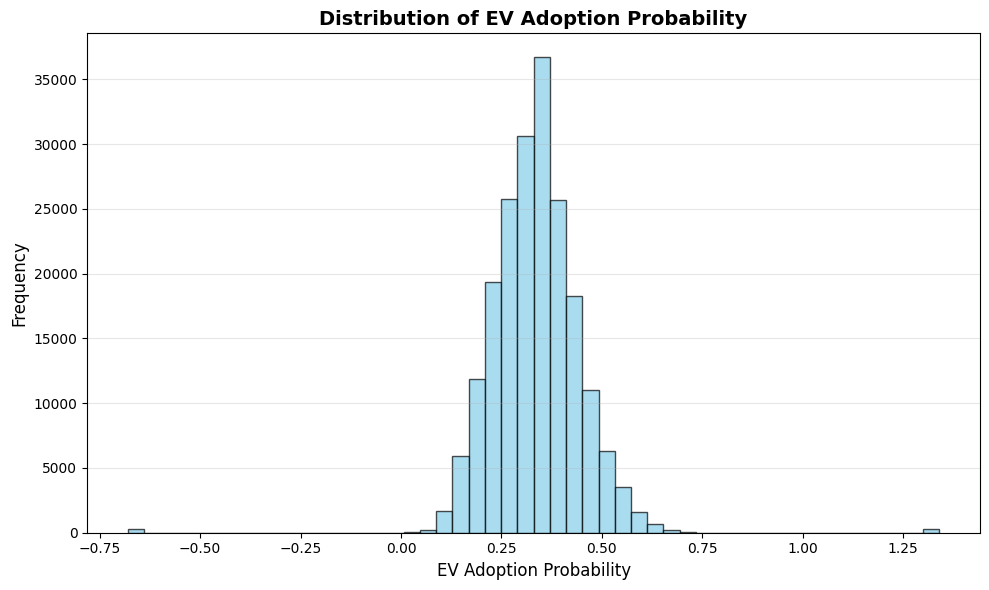

Mean EV Adoption Probability: 0.3343
Median EV Adoption Probability: 0.3300
Std Dev: 0.1126


In [42]:
# Get EV adoption probability data using PySpark
ev_adoption_data = df_filled.select("ev_adoption_probability").rdd.flatMap(lambda x: x).collect()

# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(ev_adoption_data, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
plt.xlabel('EV Adoption Probability', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of EV Adoption Probability', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
# plt.savefig('ev_adoption_histogram.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Mean EV Adoption Probability: {np.mean(ev_adoption_data):.4f}")
print(f"Median EV Adoption Probability: {np.median(ev_adoption_data):.4f}")
print(f"Std Dev: {np.std(ev_adoption_data):.4f}")

description: Shows the frequency distribution of your target variable

### 9.4 Correlation Heatmap (Features vs Target)

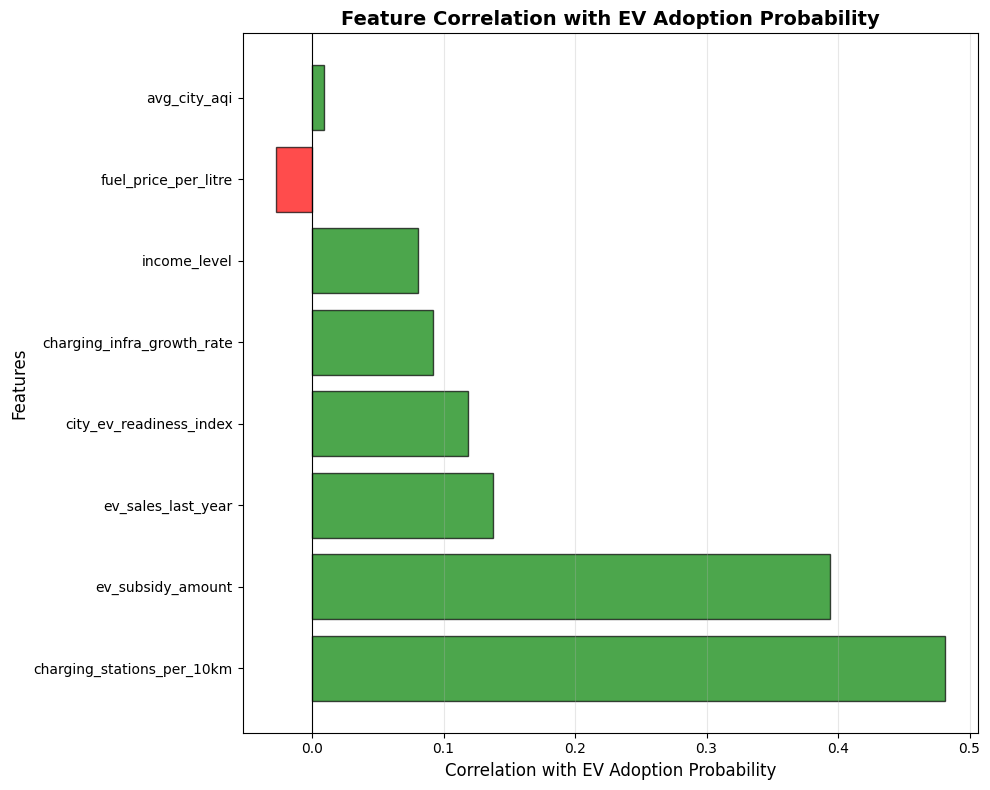

Feature Correlations with EV Adoption Probability:
  charging_stations_per_10km         : +0.4812
  ev_subsidy_amount                  : +0.3940
  ev_sales_last_year                 : +0.1375
  city_ev_readiness_index            : +0.1183
  charging_infra_growth_rate         : +0.0918
  income_level                       : +0.0806
  fuel_price_per_litre               : -0.0274
  avg_city_aqi                       : +0.0088


In [45]:
# Calculate correlations with target using PySpark
numeric_features = [
    'fuel_price_per_litre', 'avg_city_aqi', 'charging_stations_per_10km',
    'ev_subsidy_amount', 'income_level', 'city_ev_readiness_index',
    'charging_infra_growth_rate', 'ev_sales_last_year'
]

correlations = []
feature_names = []

for feature in numeric_features:
    corr = df_filled.stat.corr(feature, "ev_adoption_probability")
    if corr is not None:
        correlations.append(corr)
        feature_names.append(feature)

# Sort by absolute correlation
sorted_data = sorted(zip(feature_names, correlations), key=lambda x: abs(x[1]), reverse=True)
feature_names_sorted = [x[0] for x in sorted_data]
correlations_sorted = [x[1] for x in sorted_data]

# Plot correlation heatmap (as horizontal bar chart)
plt.figure(figsize=(10, 8))
colors = ['red' if c < 0 else 'green' for c in correlations_sorted]
plt.barh(feature_names_sorted, correlations_sorted, color=colors, edgecolor='black', alpha=0.7)
plt.xlabel('Correlation with EV Adoption Probability', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Feature Correlation with EV Adoption Probability', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
# plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("Feature Correlations with EV Adoption Probability:")
for feature, corr in sorted_data:
    print(f"  {feature:<35s}: {corr:+.4f}")

In [ ]:
description: A bar chart showing which columns (features) had the most impact on the model.

### 9.5 EV Adoption vs Charging Infrastructure

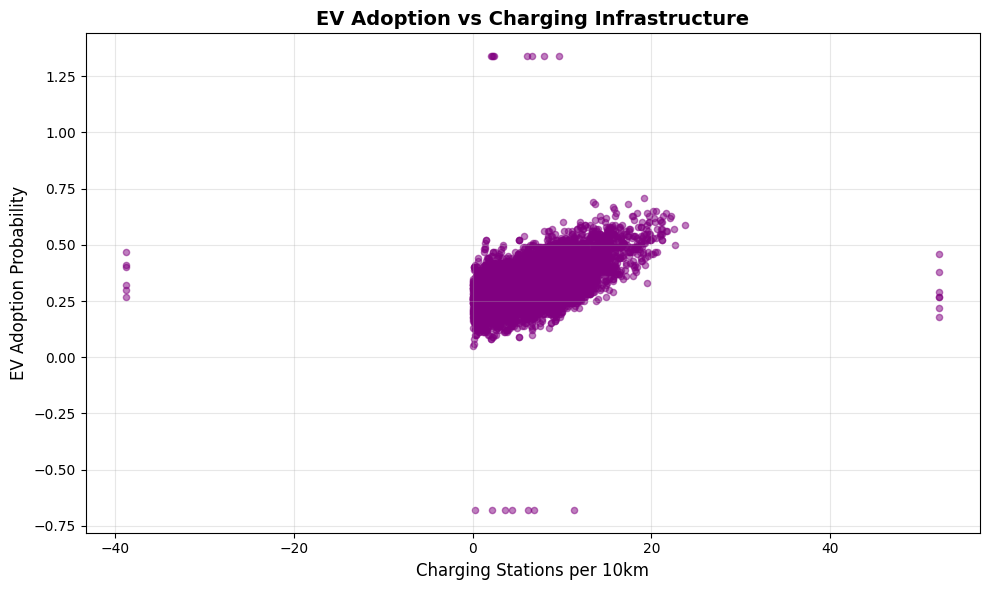

Correlation: 0.4812


In [46]:
# Sample data for scatter plot (use 5000 points for visualization)
sample_data = df_filled.select("charging_stations_per_10km", "ev_adoption_probability") \
    .sample(False, 0.025, seed=42) \
    .collect()

charging_stations = [row['charging_stations_per_10km'] for row in sample_data]
adoption = [row['ev_adoption_probability'] for row in sample_data]

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(charging_stations, adoption, alpha=0.5, s=20, color='purple')
plt.xlabel('Charging Stations per 10km', fontsize=12)
plt.ylabel('EV Adoption Probability', fontsize=12)
plt.title('EV Adoption vs Charging Infrastructure', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
# plt.savefig('ev_adoption_vs_charging_infra.png', dpi=300, bbox_inches='tight')
plt.show()

corr_charging = df_filled.stat.corr("charging_stations_per_10km", "ev_adoption_probability")
print(f"Correlation: {corr_charging:.4f}")

### 9.6 EV Adoption vs EV Subsidies

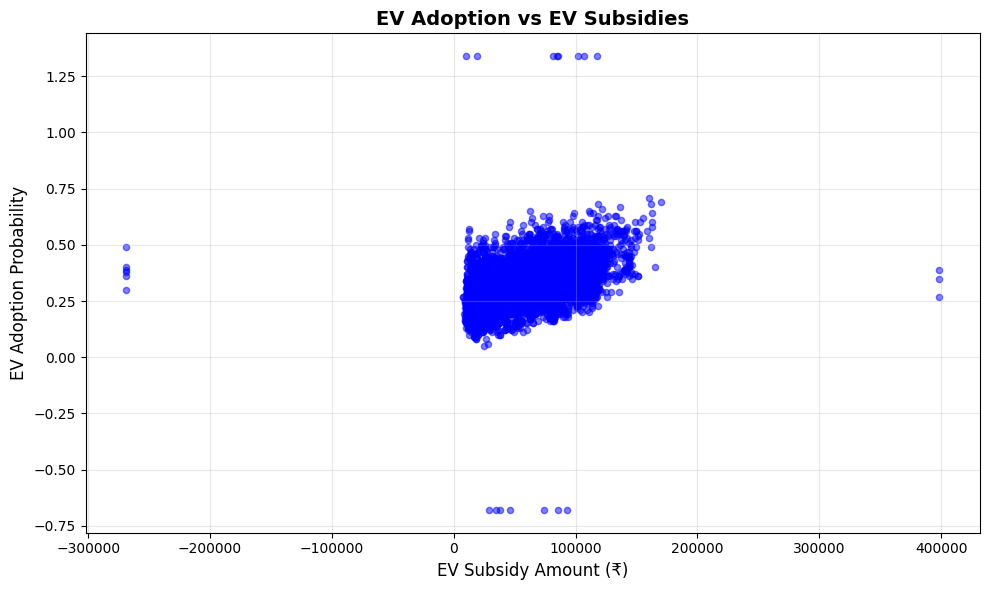

Correlation: 0.3940


In [47]:
# Sample data for scatter plot
sample_data = df_filled.select("ev_subsidy_amount", "ev_adoption_probability") \
    .sample(False, 0.025, seed=42) \
    .collect()

subsidies = [row['ev_subsidy_amount'] for row in sample_data]
adoption = [row['ev_adoption_probability'] for row in sample_data]

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(subsidies, adoption, alpha=0.5, s=20, color='blue')
plt.xlabel('EV Subsidy Amount (₹)', fontsize=12)
plt.ylabel('EV Adoption Probability', fontsize=12)
plt.title('EV Adoption vs EV Subsidies', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
# plt.savefig('ev_adoption_vs_subsidies.png', dpi=300, bbox_inches='tight')
plt.show()

corr_subsidy = df_filled.stat.corr("ev_subsidy_amount", "ev_adoption_probability")
print(f"Correlation: {corr_subsidy:.4f}")

### 9.7 EV Adoption vs Air Quality Index (AQI)

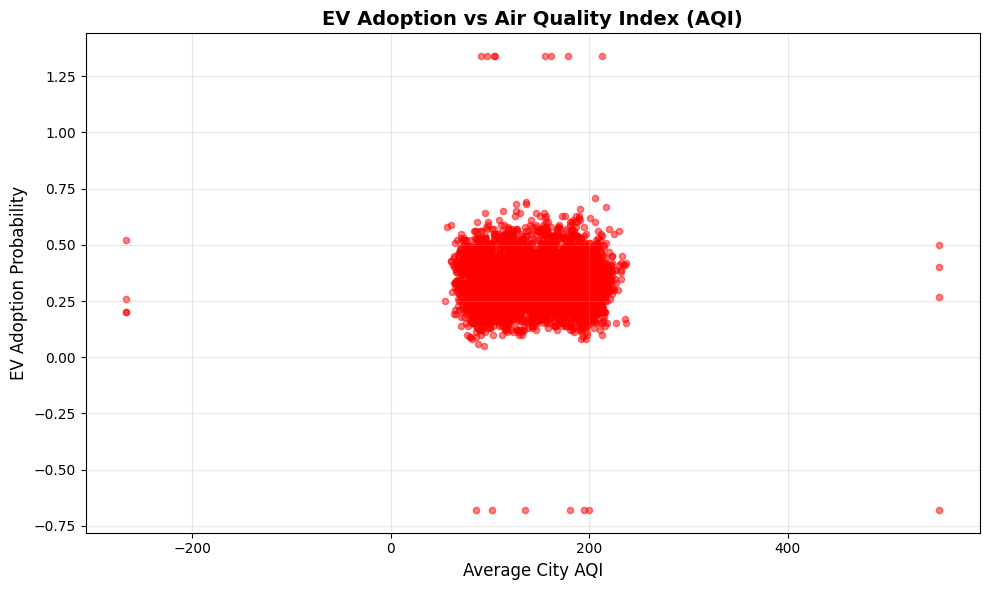

Correlation: 0.0088


In [48]:
# Sample data for scatter plot
sample_data = df_filled.select("avg_city_aqi", "ev_adoption_probability") \
    .sample(False, 0.025, seed=42) \
    .collect()

aqi = [row['avg_city_aqi'] for row in sample_data]
adoption = [row['ev_adoption_probability'] for row in sample_data]

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(aqi, adoption, alpha=0.5, s=20, color='red')
plt.xlabel('Average City AQI', fontsize=12)
plt.ylabel('EV Adoption Probability', fontsize=12)
plt.title('EV Adoption vs Air Quality Index (AQI)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
# plt.savefig('ev_adoption_vs_aqi.png', dpi=300, bbox_inches='tight')
plt.show()

corr_aqi = df_filled.stat.corr("avg_city_aqi", "ev_adoption_probability")
print(f"Correlation: {corr_aqi:.4f}")

### 9.8 EV Adoption vs Fuel Price

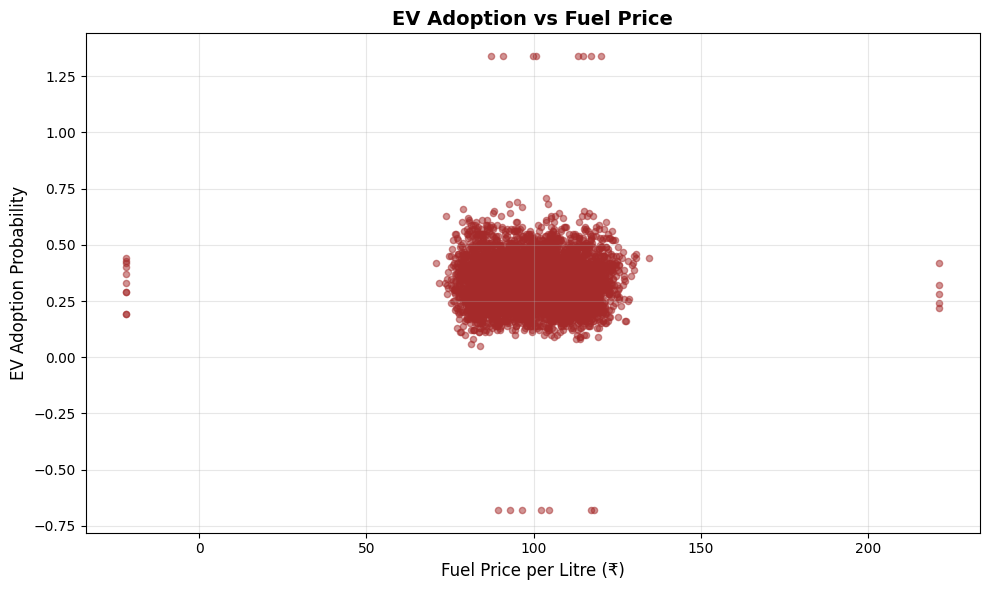

Correlation: -0.0274


In [49]:
# Sample data for scatter plot
sample_data = df_filled.select("fuel_price_per_litre", "ev_adoption_probability") \
    .sample(False, 0.025, seed=42) \
    .collect()

fuel_prices = [row['fuel_price_per_litre'] for row in sample_data]
adoption = [row['ev_adoption_probability'] for row in sample_data]

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(fuel_prices, adoption, alpha=0.5, s=20, color='brown')
plt.xlabel('Fuel Price per Litre (₹)', fontsize=12)
plt.ylabel('EV Adoption Probability', fontsize=12)
plt.title('EV Adoption vs Fuel Price', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
# plt.savefig('ev_adoption_vs_fuel_price.png', dpi=300, bbox_inches='tight')
plt.show()

corr_fuel = df_filled.stat.corr("fuel_price_per_litre", "ev_adoption_probability")
print(f"Correlation: {corr_fuel:.4f}")

## 10. Summary & Conclusion

In [52]:
print("="*90)
print("PROJECT SUMMARY")
print("="*90)
print(f"\n✓ Dataset: {df_filled.count():,} rows, {len(df_filled.columns)} columns")
print(f"✓ Missing values filled successfully")
print(f"✓ 4 regression models trained and evaluated")
print(f"✓ Best model: {best_model_name} (R² = {best_r2:.6f})")
print(f"✓ 10 comprehensive visualizations generated")
print(f"\nAll visualizations saved as PNG files in current directory.")
print("="*90)

PROJECT SUMMARY

✓ Dataset: 200,040 rows, 33 columns
✓ Missing values filled successfully
✓ 4 regression models trained and evaluated
✓ Best model: Random Forest (R² = 0.791496)
✓ 10 comprehensive visualizations generated

All visualizations saved as PNG files in current directory.


## 11. Stop Spark Session

In [54]:
# Stop Spark session
spark.stop()
print("Spark session stopped successfully")

Spark session stopped successfully
